# Distributed Acoustic Sensing (DAS) Demo

In this notebook, we analyze OOI-DAS data collected from the two submarine cables of the OOI Regional Cabled Array (RCA) extending offshore from Pacific City, Oregon. More information about the test can be found [here](https://oceanobservatories.org/pi-instrument/rapid-a-community-test-of-distributed-acoustic-sensing-on-the-ocean-observatories-initiative-regional-cabled-array/).

The examples in this notebook are adapted from [this paper](https://pubs.aip.org/asa/jel/article/3/2/026002/2874322/Distributed-acoustic-sensing-recordings-of-low).

In [1]:
# You just need to run this cell once to install the DAS4Whales package.
#!python3 -m pip install 'git+https://github.com/DAS4Whales/DAS4Whales'

# Import Required Packages

We begin by importing the necessary Python packages for data processing, visualization, and analysis.

In [2]:
import das4whales as dw
import scipy.signal as sp
import numpy as np
import matplotlib as plt

plt.rcParams['font.size'] = 32

# Dataset 1: Fin Whale Vocalizations
# DAS Data Download

In this section, we check whether the data file already exists locally. If not, we download the .hdf5 file (~850 MB) from the OOI DAS experiment (Wilcock & OOI, 2023). Depending on your internet connection, the download may take a few seconds.

In [3]:
# The dataset used in this example consists of 60-second time series recorded along 66 km of cable.

url = 'http://piweb.ooirsn.uw.edu/das/data/Optasense/NorthCable/TransmitFiber/' \
        'North-C1-LR-P1kHz-GL50m-Sp2m-FS200Hz_2021-11-03T15_06_51-0700/'\
        'North-C1-LR-P1kHz-GL50m-Sp2m-FS200Hz_2021-11-04T020002Z.h5'

filepath, filename = dw.data_handle.dl_file(url)

North-C1-LR-P1kHz-GL50m-Sp2m-FS200Hz_2021-11-04T020002Z.h5 already stored locally


# Reading Metadata

By reading the metadata of an HDF5 file, we can access acquisition parameters without loading the large associated strain data matrix. 

Note: This metadata reading function is designed for metadata recorded by an OptaSense interrogator and may need to be adapted for other interrogator models.

In [4]:
# Read HDF5 files and access metadata
# Get the acquisition parameters for the data folder and store them in a dictionary
metadata = dw.data_handle.get_acquisition_parameters(filepath, interrogator='optasense')
fs, dx, nx, ns, gauge_length, scale_factor = metadata["fs"], metadata["dx"], metadata["nx"], metadata["ns"], metadata["GL"], metadata["scale_factor"]

print(f'Sampling frequency: {metadata["fs"]} Hz')
print(f'Channel spacing: {metadata["dx"]} m')
print(f'Gauge length: {metadata["GL"]} m')
print(f'File duration: {metadata["ns"] / metadata["fs"]} s')
print(f'Cable max distance: {metadata["nx"] * metadata["dx"]/1e3:.1f} km')
print(f'Number of channels: {metadata["nx"]}')
print(f'Number of time samples: {metadata["ns"]}')

Sampling frequency: 200.0 Hz
Channel spacing: 2.0419046878814697 m
Gauge length: 51.0476188659668 m
File duration: 60.0 s
Cable max distance: 66.6 km
Number of channels: 32600
Number of time samples: 12000


# Select the Desired Channels and Channel Interval

As shown above, the channel spacing (spatial sampling along the fiber) is very fine, approximately 2 meters. The following step resamples the data spatially and selects a region of interest to reduce the size of the data matrix.

In [5]:
selected_channels_m = [20000, 65000, 10]  # list of values in meters corresponding to the starting,
                                          # ending and step wanted channels along the FO Cable
                                          # selected_channels_m = [ChannelStart_m, ChannelStop_m, ChannelStep_m]
                                          # in meters

selected_channels = [int(selected_channels_m // dx) for selected_channels_m in
                     selected_channels_m]  # list of values in channel number (spatial sample) corresponding to the starting, ending and step wanted
                                           # channels along the FO Cable
                                           # selected_channels = [ChannelStart, ChannelStop, ChannelStep] in channel
                                           # numbers

print('Begin channel #:', selected_channels[0], 
      ', End channel #: ',selected_channels[1], 
      ', step: ',selected_channels[2], 
      'equivalent to ',selected_channels[2]*dx,' m')

Begin channel #: 9794 , End channel #:  31833 , step:  4 equivalent to  8.167619  m


# Load Raw DAS Data

In [6]:
# Load DAS data
tr, time, dist, fileBeginTimeUTC = dw.data_handle.load_das_data(filepath, selected_channels, metadata)

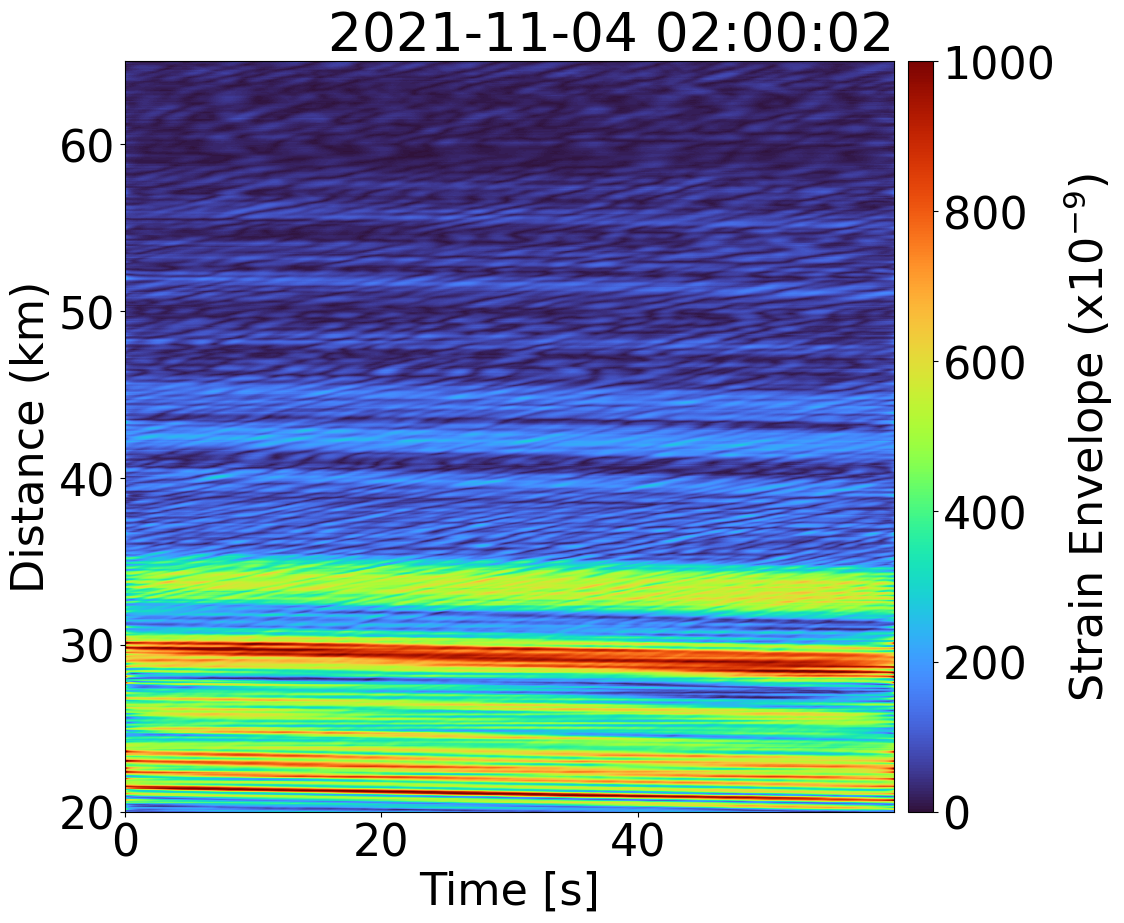

In [7]:
# Plot
dw.plot.plot_tx(sp.hilbert(tr, axis=1), time, dist, fileBeginTimeUTC, fig_size=(12, 10), v_min=0, v_max=1000)

# Bandpass and High-Pass Filtering 

Here, we apply a band-pass filter to the data and generate the corresponding time-distance (t-x) plot for analysis.

The butterworth_filter applies a Butterworth filter using second-order sections (SOS) for improved numerical stability, allowing precise control over the filter’s cutoff frequencies and order. It’s commonly used to isolate specific frequency bands in signals.

In [8]:
# Create band-pass filter for the TX plots
sos_bpfilter = dw.dsp.butterworth_filter([5, [10, 30], 'bp'], fs)

# Create high-pass filter
sos_hpfilter = dw.dsp.butterworth_filter([2, 5, 'hp'], fs)

In [9]:
# band-pass filter
trf = sp.sosfiltfilt(sos_bpfilter, tr, axis=1)

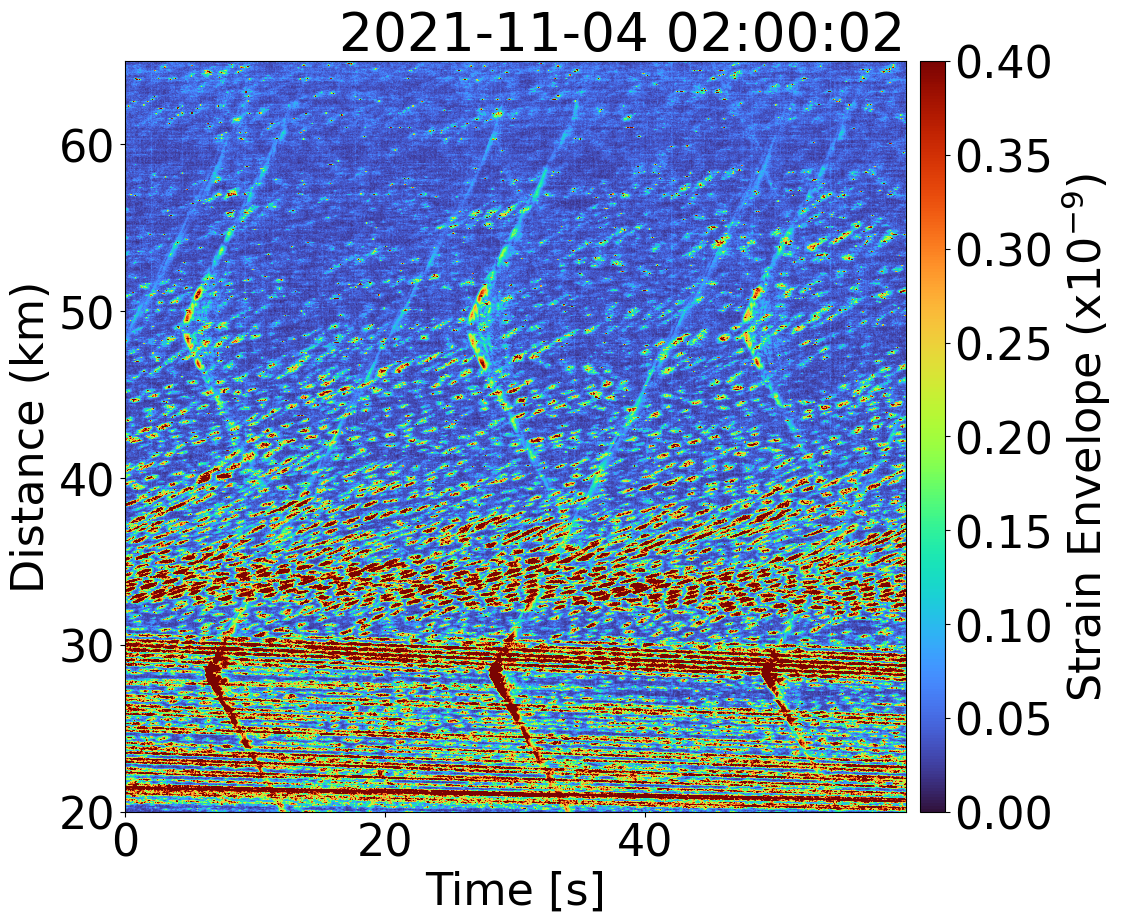

In [10]:
# Plot
dw.plot.plot_tx(sp.hilbert(trf, axis=1), time, dist, fileBeginTimeUTC, fig_size=(12, 10), v_min=0, v_max=0.4)

# Filtering in the Frequency-Wavenumber (f-k) Domain

The spatio-temporal DAS strain data is transformed into the frequency-wavenumber (f-k) domain using a 2D FFT. In this domain, a fan filter can be applied to isolate specific propagation speeds. The filtered data is then transformed back to the time-space (t-x) domain.

This process is performed using the following functions in sequence:

1) das4whales.dsp.hybrid_ninf_gs_filter_design(params): designs the fan filter
2) das4whales.dsp.fk_filter_sparsefilt(params): transforms the data to the f-k domain, applies the filter, and converts the result back to the t-x domain

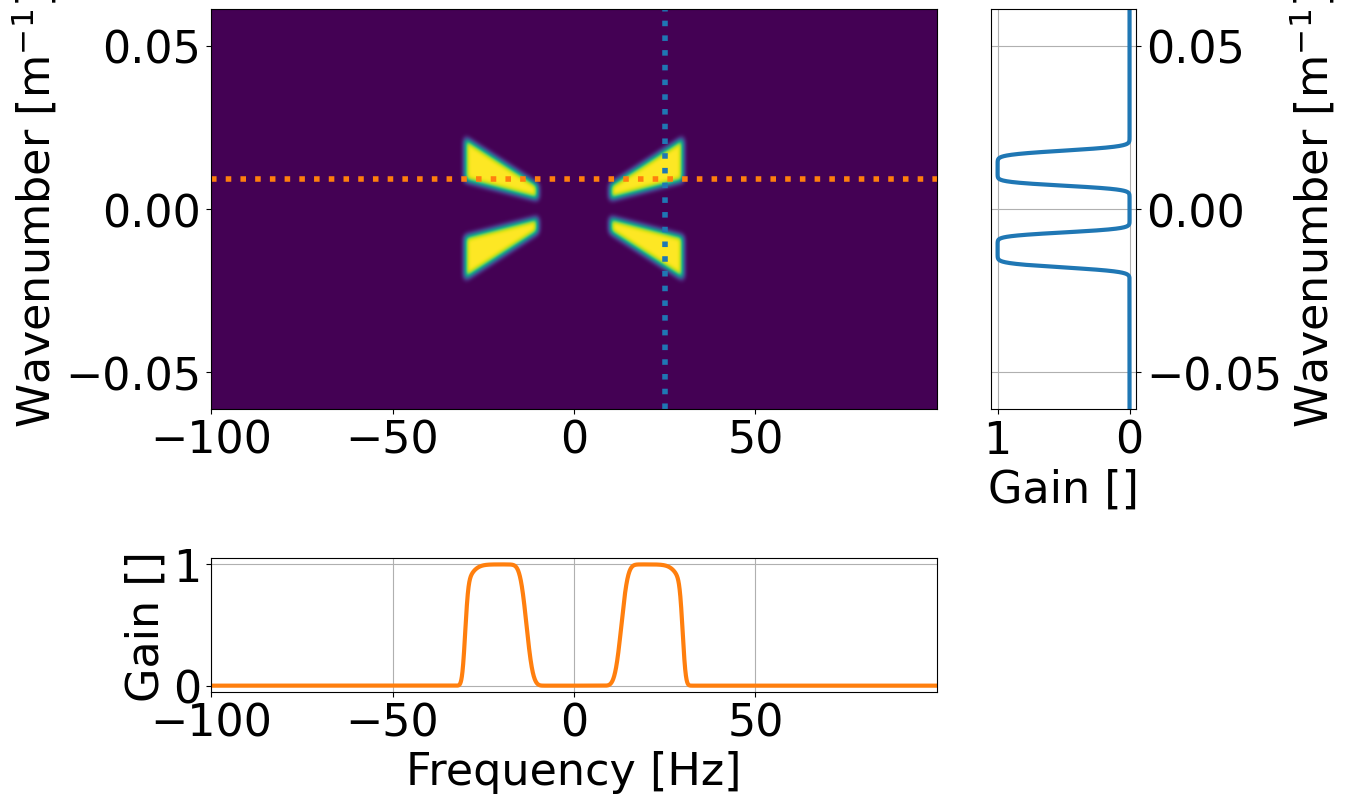

The size of the sparse filter is 0.0359 Gib
The size of the dense filter is 0.49 Gib
The compression ratio is 13.73 (92.7 %)


In [11]:
# Set the wanted parameters for the f-k filter
fk_params_s = {
    'c_min': 1400., # m.s-1
    'c_max': 3500., # m.s-1
    'fmin': 10., # Hz
    'fmax': 30. # Hz
}

# Create the f-k filter
fk_filter = dw.dsp.hybrid_ninf_gs_filter_design((tr.shape[0],tr.shape[1]), selected_channels, dx, fs, fk_params_s, display_filter=True)

# Print the compression ratio given by the sparse matrix usage
dw.tools.disp_comprate(fk_filter)

Here, we apply the f-k filter to the data to obtain the filtered spatio-temporal strain matrix.

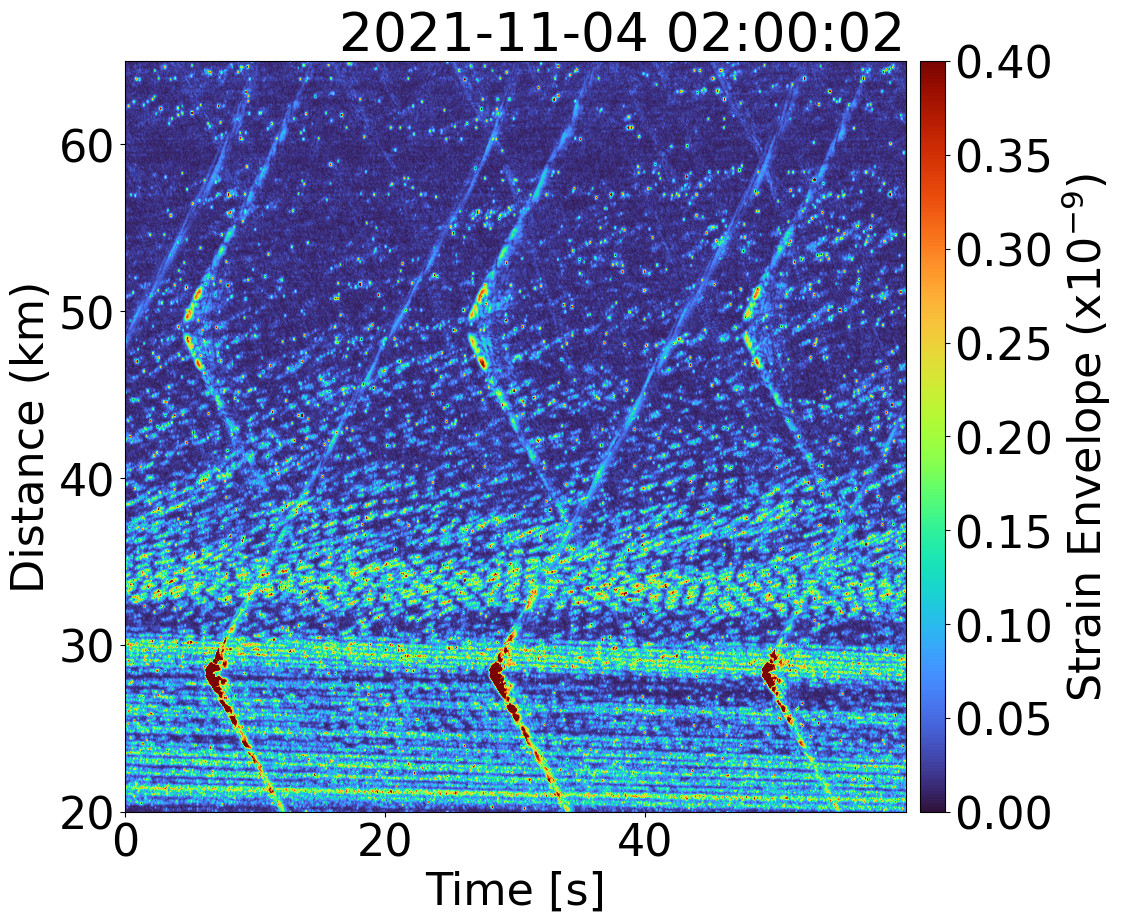

In [12]:
# If bandpassed before, set tapering=False if not set it to True to avoid edge effects
trf_fk = dw.dsp.fk_filter_sparsefilt(trf, fk_filter, tapering=False)


# To plot the envelope use sp.hilbert(trf_fk, axis=1)
# Plot
dw.plot.plot_tx(sp.hilbert(trf_fk, axis=1), time, dist, fileBeginTimeUTC, fig_size=(12, 10), v_min=0, v_max=0.4)

# f-x Domain Representation of DAS Recordings

We show a spatio-spectral representation of the DAS recordings—also known as an f-x plot to visualize the spectral content and its variation with distance.

In the following example, a Fast Fourier Transform (FFT) is applied to each channel using 2-second segments of the spatio-temporal DAS data. The segment duration is defined by the parameter win_s.

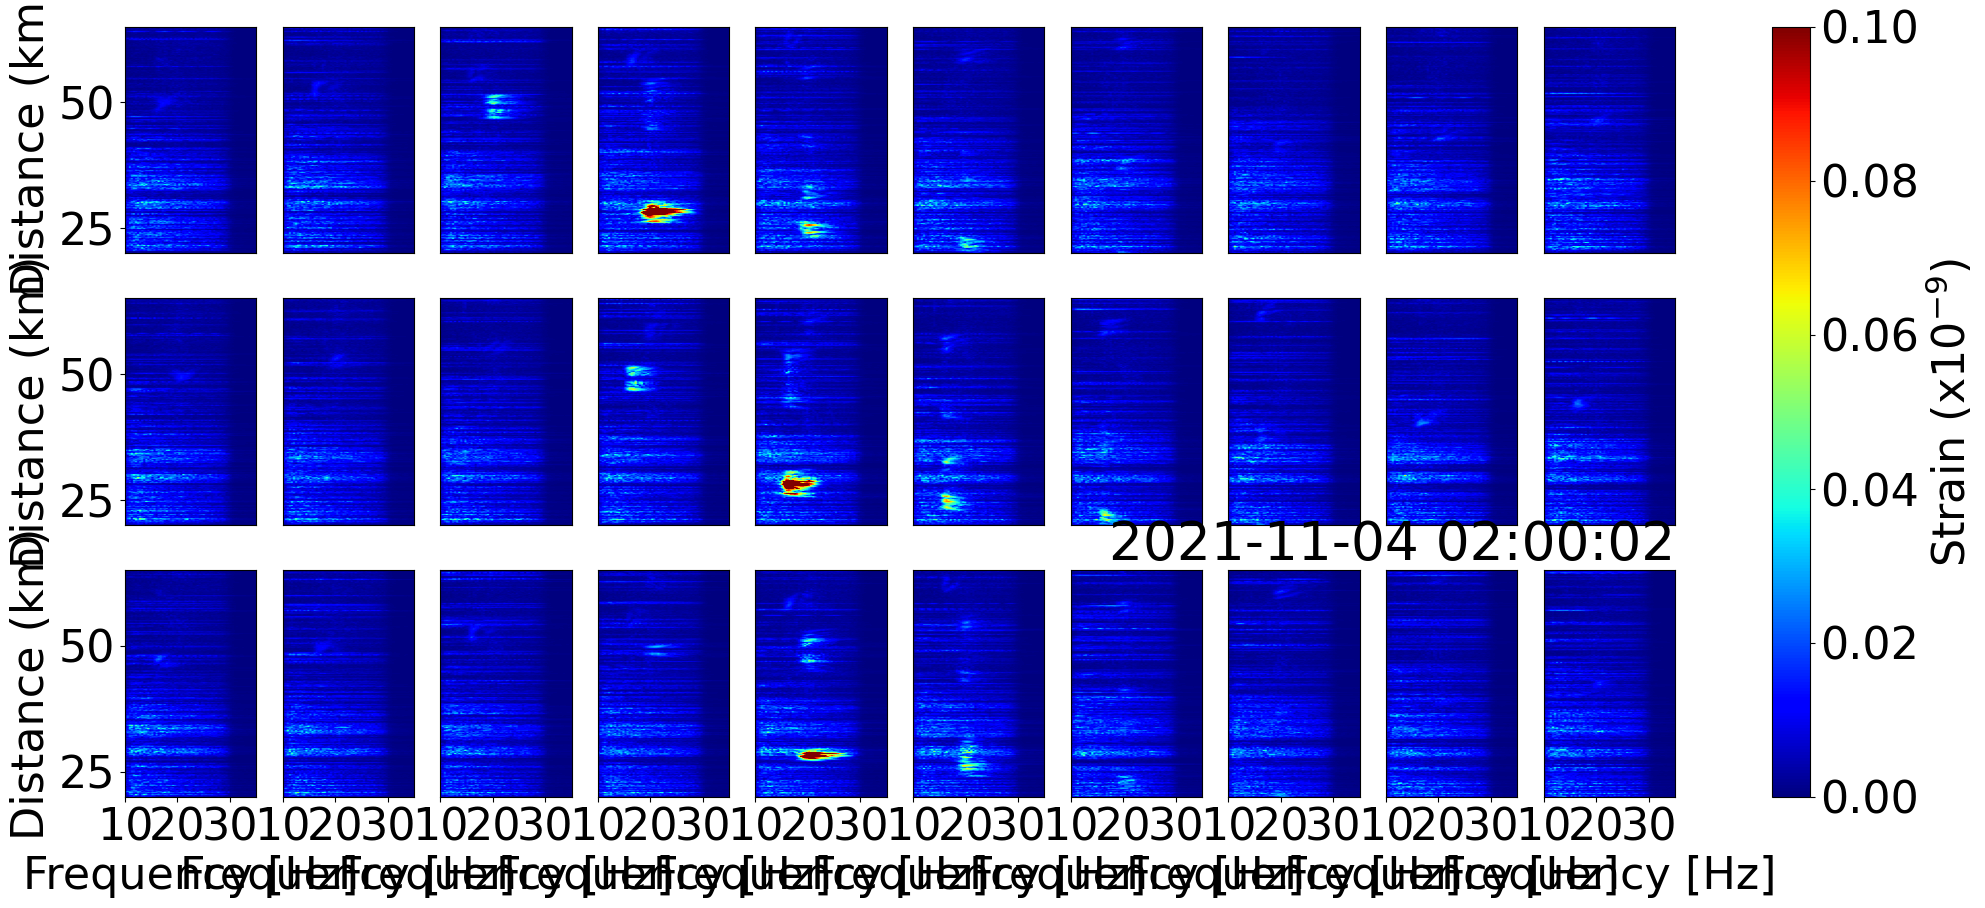

In [13]:
# Spatio-spectral plot
dw.plot.plot_fx(trf_fk, dist, fs, title_time_info=fileBeginTimeUTC, win_s=2,
                nfft=512,  f_min=10, f_max=35, fig_size=(25, 10), 
                v_min = 0, v_max = 0.1)

# Inspect Spectrogram and Listen to Audio from a Selected Channel
In this step, we choose a single channel from the DAS dataset and visualize its time–frequency content using a spectrogram. We also convert the strain signal into an audio waveform for playback, enabling auditory inspection of the acoustic features. This approach helps identify tonal signals, transients, and other frequency-dependent phenomena in the data.

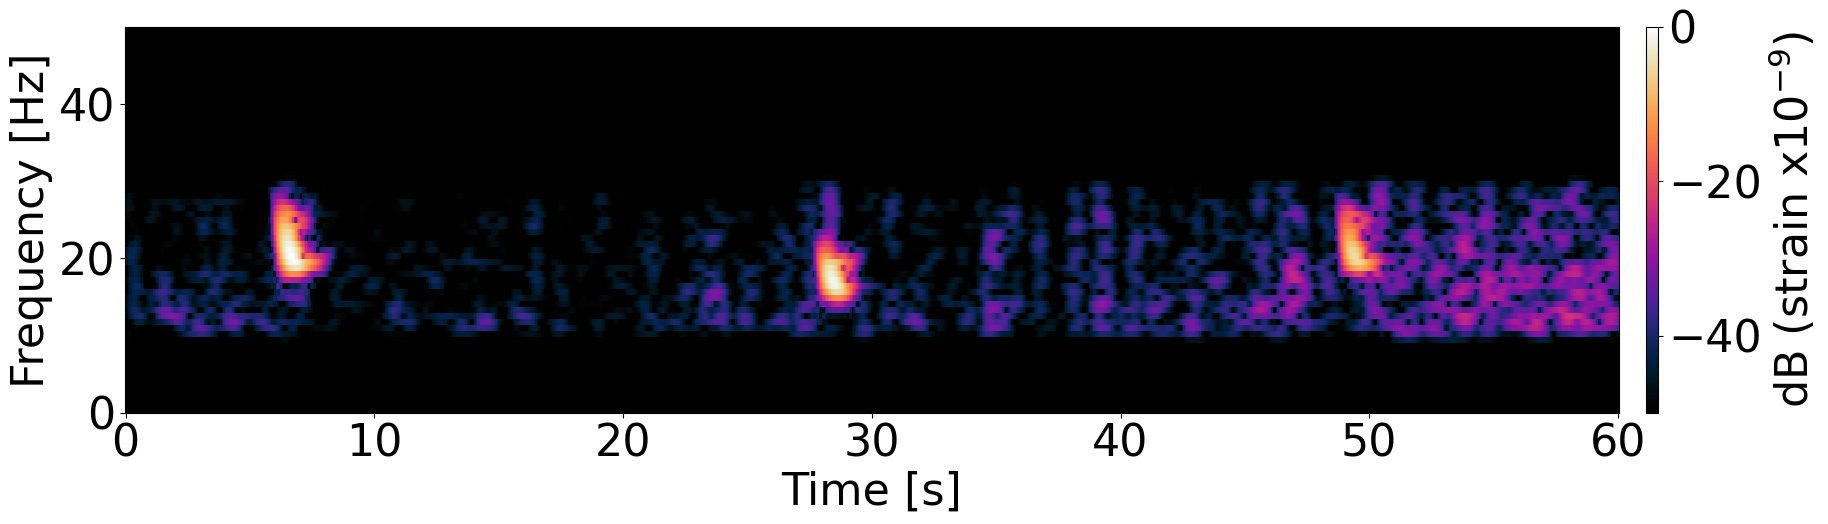

In [14]:
from IPython.display import Audio, display

# read one channel only as audio
selected_chan = 28000 # (m)
idx = (np.abs(dist - selected_chan)).argmin()

# Spectrogram
p,tt,ff = dw.dsp.get_spectrogram(trf_fk[idx,:], fs, nfft=256, overlap_pct=0.95)

dw.plot.plot_spectrogram(p, tt,ff, f_min = 0, f_max = 50, v_min=-50)

display(Audio(data=trf_fk[idx,:], rate=fs*5))

### 🔍 Activity 1: View a Blue Whale Call in DAS Data

To observe an example of a **blue whale call**, download and inspect the following raw DAS file:

📁 **File URL**:  
http://piweb.ooirsn.uw.edu/das/data/Optasense/SouthCable/TransmitFiber/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T16_09_15-0700/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-02T103614Z.h5


### 🔍 Activity 2: View a Ship Signal in DAS Data

To observe an example of a **ship signal**, download and inspect the following raw DAS file:

📁 **File URL**:  
http://piweb.ooirsn.uw.edu/das/data/Optasense/SouthCable/TransmitFiber/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T16_09_15-0700/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-03T012514Z.h5